In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import os
import pickle
import sys
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

In [4]:
system_settings = {
    "surface_name": 'SrTiO3(001)',
    "relax_atoms": True,
    "relax_steps": 5,
    "offset": True,
    "offset_data": os.path.join(
        os.getcwd(),
        "data/nff",
        "offset_data.json",
    ),
    "optimizer": "BFGS",
    "cutoff": 5.0,
    "calc_name": "kim",
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0, # no annealing
    "temperature": 1.0, # in terms of kbT
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "num_sweeps": 10,
    "sweep_size": 64,
}

calc_params = {
    "chem_pots": sampling_settings["chem_pots"],
    "offset_data": json.load(open(system_settings["offset_data"], "r")),
}

Obtain adsorption sites

In [5]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
# new standardized params
# ads_positions = site_finder.find_adsorption_sites(
#     put_inside=True,
#     symm_reduce=False,
#     near_reduce=system_settings['near_reduce'],
#     distance=system_settings["planar_distance"],
#     no_obtuse_hollow=system_settings['no_obtuse_hollow'],
# )["all"]

# old params
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites["all"]

print("adsorption coordinates are")
print(ads_positions)

sweep_size = len(ads_positions)

adsorption coordinates are
[array([-0.   , -0.029, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([-0.   ,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829]), array([ 1.968,  4.131, 18.782]), array([ 3.936, -0.029, 18.87 ]), array([ 5.903,  1.951, 18.829]), array([ 5.903,  0.146, 18.782]), array([ 3.936,  3.956, 18.87 ]), array([ 5.903,  5.936, 18.829]), array([ 5.903,  4.131, 18.782]), array([ 9.839, 30.936, 18.806]), array([ 8.855, 30.848, 18.85 ]), array([29.517, 30.936, 18.806]), array([30.5  , 30.848, 18.85 ]), array([14.758, 15.998, 18.826]), array([15.742, 13.906, 18.829]), array([30.5  , 28.856, 18.85 ]), array([ 8.855, 28.856, 18.85 ]), array([10.823, 30.848, 18.85 ]), array([14.758, 24.871, 18.85 ]), array([16.726, 24.871, 18.85 ]), array([15.742, 25.861, 18.829]), array([30.5  , 27.953, 18.826]), array([29.517, 28.943, 18.806]), array([28.533, 28.856, 18.85 ]), array([28.533, 27.953, 18.826]), array([12.79 , 15.998, 18.826]), array([12.79 , 

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [6]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_params)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [7]:
# set attributes
slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=system_settings["cutoff"],
    props={"energy": 0, "energy_grad": []},
    calculator=nff_surf_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

surface = SurfaceSystem(slab_batch, ads_positions, nff_surf_calc, system_info=system_settings)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
ads coords is [-0.    -0.029 18.87 ]
ads coords is [ 1.968  1.951 18.829]
ads coords is [ 1.968  0.146 18.782]
ads coords is [-0.     3.956 18.87 ]
ads coords is [ 1.968  5.936 18.829]
ads coords is [ 1.968  4.131 18.782]
ads coords is [ 3.936 -0.029 18.87 ]
ads coords is [ 5.903  1.951 18.829]
ads coords is [ 5.903  0.146 18.782]
ads coords is [ 3.936  3.956 18.87 ]
ads coords is [ 5.903  5.936 18.829]
ads coords is [ 5.903  4.131 18.782]
ads coords is [ 9.839 30.936 18.806]
ads coords is [ 8.855 30.848 18.85 ]
ads coords is [29.517 30.936 18.806]
ads 

2024-02-12 17:50:21,762|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-02-12 17:50:21,763|INFO|number of pristine atoms is 60
2024-02-12 17:50:21,764|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2024-02-12 17:50:21,765|INFO|surface indices are []


In [8]:
surface.get_potential_energy()

array([-467.541], dtype=float32)

In [9]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [10]:
from mcmc.energy import slab_energy
slab_energy(surface, offset=True, offset_data=system_settings["offset_data"])

      Step     Time          Energy         fmax
BFGS:    0 17:50:22     -467.521851        0.0000


(12.49005126953125,
 0.30546674132347107,
 1.3775752782821655,
 0.0250319242477417,
 [])

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-02-12 17:50:22,080|INFO|there are 60 atoms in pristine slab
2024-02-12 17:50:22,081|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-02-12 17:50:22,082|INFO|In pristine slab, there are a total of 72 sites


      Step     Time          Energy         fmax
BFGS:    0 17:50:22     -467.521851        0.0000


2024-02-12 17:50:22,113|INFO|running for 64 iterations per run over a total of 10 runs
2024-02-12 17:50:22,114|INFO|starting with iteration 0
2024-02-12 17:50:22,115|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 17:50:22     -449.987701       77.9751
BFGS:    1 17:50:22     -460.289459       29.8443
BFGS:    2 17:50:22     -463.128693       16.8015
BFGS:    3 17:50:22     -464.905914        6.3706
BFGS:    4 17:50:22     -465.336517        2.5506
BFGS:    5 17:50:22     -465.470673        1.8618
      Step     Time          Energy         fmax
BFGS:    0 17:50:22     -474.312134        2.3388
BFGS:    1 17:50:22     -474.385254        2.0533
BFGS:    2 17:50:22     -474.682373        1.7964
BFGS:    3 17:50:22     -474.969818        2.5656
BFGS:    4 17:50:22     -475.444916        2.5073
BFGS:    5 17:50:23     -475.952484        2.7994
      Step     Time          Energy         fmax
BFGS:    0 17:50:23     -469.891357        0.6995
BFGS:    1 17:50:23     -469.898285        0.6840
BFGS:    2 17:50:23     -470.012451        0.4821
BFGS:    3 17:50:23     -470.014069        1.3009
BFGS:  

2024-02-12 17:50:53,125|INFO|current energy is 15.451141357421875, calculated energy is 15.451141357421875
2024-02-12 17:50:53,126|INFO|optim structure has Energy = 15.451+/-0.056
2024-02-12 17:50:53,126|INFO|average force error = 0.059
2024-02-12 17:50:53,132|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:50:53     -473.674225      116.4342
BFGS:    1 17:50:53     -486.835693       38.9580
BFGS:    2 17:50:53     -496.969818       31.1209
BFGS:    3 17:50:53     -508.101227       16.1883
BFGS:    4 17:50:53     -515.185669        9.4586
BFGS:    5 17:50:53     -519.607422        4.8599
      Step     Time          Energy         fmax
BFGS:    0 17:50:53    -3310.107178    64123.0218
BFGS:    1 17:50:53     -471.850189      117.0272
BFGS:    2 17:50:53     -485.872589       31.7431
BFGS:    3 17:50:53     -493.214996       84.9961
BFGS:    4 17:50:53     -501.887207       19.8363
BFGS:    5 17:50:54     -508.735138       17.3834
      Step     Time          Energy         fmax
BFGS:    0 17:50:54     -485.770599       76.5277
BFGS:    1 17:50:54     -493.717865       11.6985
BFGS:    2 17:50:54     -497.196075        7.2277
BFGS:    3 17:50:54     -500.448395        4.0735
BFGS:    4 17:50:54     -502.092865        8.2770
BFG

2024-02-12 17:51:23,829|INFO|current energy is 17.97735595703125, calculated energy is 17.977294921875
2024-02-12 17:51:23,829|INFO|optim structure has Energy = 17.977+/-0.122
2024-02-12 17:51:23,830|INFO|average force error = 0.074
2024-02-12 17:51:23,836|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:51:24     -439.241180       91.0884
BFGS:    1 17:51:24     -469.313446       36.7762
BFGS:    2 17:51:24     -488.823975       21.0376
BFGS:    3 17:51:24     -501.019928       12.2778
BFGS:    4 17:51:24     -510.734985        7.8066
BFGS:    5 17:51:24     -518.375000        5.4363
      Step     Time          Energy         fmax
BFGS:    0 17:51:24     -406.738861      142.4832
BFGS:    1 17:51:24     -450.916992       59.6858
BFGS:    2 17:51:24     -473.085693       40.3114
BFGS:    3 17:51:24     -487.694366       22.7102
BFGS:    4 17:51:24     -499.878540       19.4055
BFGS:    5 17:51:24     -509.429810       12.2989
      Step     Time          Energy         fmax
BFGS:    0 17:51:25    34315.894531   814983.7097
BFGS:    1 17:51:25     -422.417145      391.9381
BFGS:    2 17:51:25     -444.222809      398.0091
BFGS:    3 17:51:25     -472.318329      192.0973
BFGS:    4 17:51:25     -488.677826       14.2884
BFG

2024-02-12 17:51:56,743|INFO|current energy is 8.635101318359375, calculated energy is 8.635101318359375
2024-02-12 17:51:56,743|INFO|optim structure has Energy = 8.635+/-0.060
2024-02-12 17:51:56,744|INFO|average force error = 0.042
2024-02-12 17:51:56,750|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:51:56     -447.084320       75.6627
BFGS:    1 17:51:56     -468.522797       28.0166
BFGS:    2 17:51:56     -482.401886       17.1262
BFGS:    3 17:51:57     -491.675262       11.3683
BFGS:    4 17:51:57     -498.497070        8.2641
BFGS:    5 17:51:57     -503.801025        6.3451
      Step     Time          Energy         fmax
BFGS:    0 17:51:57     -452.238037       75.0254
BFGS:    1 17:51:57     -473.528290       27.8250
BFGS:    2 17:51:57     -486.899017       16.2523
BFGS:    3 17:51:57     -496.347260       10.2578
BFGS:    4 17:51:57     -503.194977        6.6960
BFGS:    5 17:51:57     -508.380035        4.9624
      Step     Time          Energy         fmax
BFGS:    0 17:51:57     -449.372894       74.0838
BFGS:    1 17:51:57     -470.871582       27.6079
BFGS:    2 17:51:57     -484.347168       15.7903
BFGS:    3 17:51:58     -493.912079        9.7167
BFGS:    4 17:51:58     -500.523224        5.9811
BFG

2024-02-12 17:52:28,376|INFO|current energy is 6.2110595703125, calculated energy is 6.2110595703125
2024-02-12 17:52:28,377|INFO|optim structure has Energy = 6.211+/-0.144
2024-02-12 17:52:28,377|INFO|average force error = 0.051
2024-02-12 17:52:28,384|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:52:28   309722.625000  8731367.4072
BFGS:    1 17:52:28     -360.622803     1590.9084
BFGS:    2 17:52:28     -378.822174     1505.0002
BFGS:    3 17:52:28     -395.807129     1299.4303
BFGS:    4 17:52:28     -415.420319      998.9948
BFGS:    5 17:52:28     -434.547119      663.7646
      Step     Time          Energy         fmax
BFGS:    0 17:52:28    34276.269531   814931.5194
BFGS:    1 17:52:29     -461.452972      434.8115
BFGS:    2 17:52:29     -471.100708      411.4737
BFGS:    3 17:52:29     -481.593750      374.4440
BFGS:    4 17:52:29     -490.696167      304.2468
BFGS:    5 17:52:29     -500.719574      161.6248
      Step     Time          Energy         fmax
BFGS:    0 17:52:29     -468.798370       67.2449
BFGS:    1 17:52:29     -483.901703       32.3879
BFGS:    2 17:52:29     -492.699951       21.4707
BFGS:    3 17:52:29     -500.425629       13.0203
BFGS:    4 17:52:29     -506.397858        6.9781
BFG

2024-02-12 17:52:59,451|INFO|current energy is 10.3612060546875, calculated energy is 10.3612060546875
2024-02-12 17:52:59,451|INFO|optim structure has Energy = 10.361+/-0.214
2024-02-12 17:52:59,452|INFO|average force error = 0.067
2024-02-12 17:52:59,458|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:52:59     -467.584961       67.6702
BFGS:    1 17:52:59     -484.986938       30.9661
BFGS:    2 17:52:59     -497.285919       20.8818
BFGS:    3 17:52:59     -506.823334       13.1956
BFGS:    4 17:52:59     -514.610413        7.8090
BFGS:    5 17:52:59     -520.551941        4.5719
      Step     Time          Energy         fmax
BFGS:    0 17:53:00     -487.710785       21.7488
BFGS:    1 17:53:00     -500.421478        9.8546
BFGS:    2 17:53:00     -510.534088        7.6332
BFGS:    3 17:53:00     -518.575623        5.3576
BFGS:    4 17:53:00     -523.972168        4.5626
BFGS:    5 17:53:00     -527.434326        3.6681
      Step     Time          Energy         fmax
BFGS:    0 17:53:00    34318.828125   816379.0229
BFGS:    1 17:53:00     -425.025299      422.1548
BFGS:    2 17:53:00     -446.699463      392.5554
BFGS:    3 17:53:00     -465.260406      141.3860
BFGS:    4 17:53:00     -478.409058       19.3096
BFG

2024-02-12 17:53:29,614|INFO|current energy is 6.91754150390625, calculated energy is 6.91754150390625
2024-02-12 17:53:29,615|INFO|optim structure has Energy = 6.918+/-0.223
2024-02-12 17:53:29,616|INFO|average force error = 0.058
2024-02-12 17:53:29,622|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:53:29     -473.977692       58.9654
BFGS:    1 17:53:29     -490.851227       16.5440
BFGS:    2 17:53:29     -501.655060       10.9713
BFGS:    3 17:53:29     -511.236664        8.5838
BFGS:    4 17:53:30     -517.499268        6.1190
BFGS:    5 17:53:30     -521.467041        5.1162
      Step     Time          Energy         fmax
BFGS:    0 17:53:30     -439.347290      102.4751
BFGS:    1 17:53:30     -475.189819       35.1074
BFGS:    2 17:53:30     -490.726227       37.7857
BFGS:    3 17:53:30     -503.638092       20.3873
BFGS:    4 17:53:30     -513.955261       12.4564
BFGS:    5 17:53:30     -521.146912        6.6429
      Step     Time          Energy         fmax
BFGS:    0 17:53:30     -405.363495      961.6680
BFGS:    1 17:53:30     -464.225098       55.4018
BFGS:    2 17:53:30     -487.584808       20.4606
BFGS:    3 17:53:30     -498.488068       17.9402
BFGS:    4 17:53:30     -509.473358       11.2768
BFG

2024-02-12 17:53:59,519|INFO|current energy is 6.4285888671875, calculated energy is 6.4285888671875
2024-02-12 17:53:59,519|INFO|optim structure has Energy = 6.429+/-0.329
2024-02-12 17:53:59,520|INFO|average force error = 0.064
2024-02-12 17:53:59,526|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:53:59     -448.136597      113.2215
BFGS:    1 17:53:59     -474.746857       24.6182
BFGS:    2 17:53:59     -488.868652       20.2312
BFGS:    3 17:53:59     -499.058350       13.3621
BFGS:    4 17:53:59     -506.676666        9.2593
BFGS:    5 17:53:59     -512.262878        5.1546
      Step     Time          Energy         fmax
BFGS:    0 17:54:00     -446.877289       98.9812
BFGS:    1 17:54:00      112.994591     9959.0947
BFGS:    2 17:54:00     -400.785614     1280.8899
BFGS:    3 17:54:00     -471.277618       33.0745
BFGS:    4 17:54:00     -480.377472       13.1290
BFGS:    5 17:54:00     -488.892731        8.6605
      Step     Time          Energy         fmax
BFGS:    0 17:54:00     -463.004974       55.3408
BFGS:    1 17:54:00     -481.516968       29.7062
BFGS:    2 17:54:00     -492.665985       19.8027
BFGS:    3 17:54:00     -501.009979       11.9118
BFGS:    4 17:54:00     -507.932037        6.9097
BFG

2024-02-12 17:54:29,058|INFO|current energy is 7.98211669921875, calculated energy is 7.98211669921875
2024-02-12 17:54:29,058|INFO|optim structure has Energy = 7.982+/-0.223
2024-02-12 17:54:29,059|INFO|average force error = 0.053
2024-02-12 17:54:29,065|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:54:29     -439.535553      106.5012
BFGS:    1 17:54:29     -412.257721      726.2954
BFGS:    2 17:54:29     -453.915894      291.2916
BFGS:    3 17:54:29     -468.469330       36.9810
BFGS:    4 17:54:29     -484.022980       29.9072
BFGS:    5 17:54:29     -494.432770       18.2562
      Step     Time          Energy         fmax
BFGS:    0 17:54:29     -467.399780       35.0684
BFGS:    1 17:54:29     -489.131073       25.1104
BFGS:    2 17:54:29     -499.740448       12.3920
BFGS:    3 17:54:29     -510.099274       10.3314
BFGS:    4 17:54:29     -517.691589        5.7283
BFGS:    5 17:54:29     -523.721924        5.8757
      Step     Time          Energy         fmax
BFGS:    0 17:54:30     -432.072418      117.2899
BFGS:    1 17:54:30     -468.890472       46.1144
BFGS:    2 17:54:30     -487.810150       47.3371
BFGS:    3 17:54:30     -506.045410       17.8352
BFGS:    4 17:54:30     -518.052307        9.5711
BFG

2024-02-12 17:54:58,125|INFO|current energy is 6.1942138671875, calculated energy is 6.19427490234375
2024-02-12 17:54:58,126|INFO|optim structure has Energy = 6.194+/-0.180
2024-02-12 17:54:58,126|INFO|average force error = 0.048
2024-02-12 17:54:58,132|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:54:58      194.565674    11354.8936
BFGS:    1 17:54:58     -458.524689       49.8518
BFGS:    2 17:54:58     -478.625854       28.1693
BFGS:    3 17:54:58     -491.352814       24.9354
BFGS:    4 17:54:58     -502.191376       20.5265
BFGS:    5 17:54:58     -510.040131       11.8996
      Step     Time          Energy         fmax
BFGS:    0 17:54:58     -428.352386       82.8811
BFGS:    1 17:54:58     -433.165436      197.8630
BFGS:    2 17:54:58     -462.733398       37.4450
BFGS:    3 17:54:58     -478.067963       15.2805
BFGS:    4 17:54:58     -489.896576       14.9376
BFGS:    5 17:54:58     -498.388824       40.0716
      Step     Time          Energy         fmax
BFGS:    0 17:54:59    34350.871094   814799.4205
BFGS:    1 17:54:59     -375.795563      632.4631
BFGS:    2 17:54:59     -405.385742      501.0994
BFGS:    3 17:54:59     -452.234161      243.2256
BFGS:    4 17:54:59     -456.548492      280.8477
BFG

2024-02-12 17:55:27,480|INFO|current energy is 10.2626953125, calculated energy is 10.2626953125
2024-02-12 17:55:27,481|INFO|optim structure has Energy = 10.263+/-0.238
2024-02-12 17:55:27,481|INFO|average force error = 0.062


Time taken = 305.6719207474962 seconds


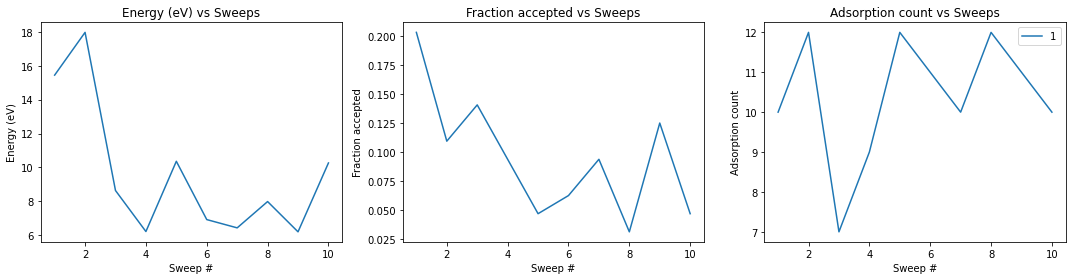

In [11]:
mcmc = MCMC(
    system_settings['surface_name'], 
    calc=nff_surf_calc, 
    canonical=False, 
    testing=False, 
    element=element, 
    adsorbates=list(sampling_settings['chem_pots'].keys()), 
    relax=system_settings['relax_atoms'], 
    relax_steps=system_settings['relax_steps'],
    offset=system_settings['offset'],
    offset_data=system_settings['offset_data'],
    optimizer=system_settings['optimizer']) # relax atoms with manual offset TODO fix this!

start = perf_counter()
# call the main function
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings['num_sweeps'],
    sweep_size=sampling_settings['sweep_size'],
    start_temp=sampling_settings['temperature'],
    pot=list(sampling_settings['chem_pots'].values()),
    alpha=sampling_settings['alpha'],
    surface=surface
    )
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

In [12]:
sampling_settings['chem_pots'].keys()

dict_keys(['Sr', 'Ti', 'O'])

In [13]:
sampling_settings['chem_pots'].values()

dict_values([-2, 0, 0])

Save structures for later use in latent space clustering or analysis

In [14]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)